# Final Project Report: Airbnb & Neighborhood Crime
*Spring 2023, HCDE 410: Human Data Interation*

## Introduction
### Motivation and Problem Statement
My goal is to be more informed about the consequences of homestay properties in local neighborhoods. For the purpose of this project, I will mostly focus the scope on finding a correlation between Airbnbs and crime reports in Seattle, rather than trying to prove causation. As a stretch goal, I would also want to figure out a way to rate the severity of the crime, not just the quantity of the reports.

I plan to create a map visualization of Airbnbs and reported crime in Seattle. At first glance, this can seem useful for people who are worried about safety while planning trips or vacations in the Seattle area. However, it is important to note that the presence of crime reports is not a sufficient measure of safety. The decontextualization of large datasets like the ones used in this project can lead to distorted visualizations. Thus, it is important to be careful and thoughtful when presenting these findings, especially since this topic can instill fear in the public.

### Data Selected
For this project, I plan to use the following two datasets:
* [Seattle Police Department (SPD) Crime Data (2008-present)](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5)
    * License: Public Domain
* [Inside Airbnb (skip to Seattle, Washington, United States)](http://insideairbnb.com/get-the-data/)
    * License: [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/)

Potential ethical considerations to using these datasets are anonymity and misinterpretation of crime severity. Making visualizations of reported crime in the same neighborhoods as the Airbnb listings might discourage people from booking and affect their reviews. Another consideration is that the data only contains reported crime. Particular types of crime could be underreported, meaning the data is not completely representative of Seattle.

### Background and Related Work
The effect of homestays has already been researched since the rise of companies like Airbnb. According to a [2021 study about Airbnb and neighborhood crime](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0253315), their findings support “the notion that the prevalence of Airbnb listings erodes the natural ability of a neighborhood to prevent crime.” A [different study](https://thecrimereport.org/2021/08/06/is-there-a-link-between-airbnb-and-neighborhood-crime-rates/) focused on the different types of Airbnb listings and their correlation with crime. This inspired me to try to find the geospatial correlation between Airbnb clusters and the different types of crime and their severity.

## Research Questions
The goal of this project is to create a visualization of reported crime and Airbnbs in the Seattle area and confirm the relationship (or lack thereof) between Airbnbs and local crime. The motivation behind this project was to learn and see which Airbnbs are located in low-crime areas so I, and other users, can be more informed about the historic crime rates and consequences of homestay properties in local neighborhoods.

**Hypotheses:** Areas with increased Airbnb listings will have higher rates of reported crime.

**Research Questions:**
* Which areas have the most and least Airbnbs? Crime rates?
* Which offense types are the most and least frequent?
* What is the relationship between Airbnbs and crime rates?

## Data-Cleaning and Analysis
First, I want to import all the necessary Python libraries, such as the [matplotlib](https://matplotlib.org/stable/api/index.html), [Plotly API](https://plotly.com/python/getting-started/), and more.

In [1]:
# for data analysis
import pandas as pd
import plotly.express as px

import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# for data-cleaning
import json
import csv
import requests
from pprint import pprint

Then, I can start getting the data ready from my two datasets. The following is my process for ["data wrangling"](https://en.wikipedia.org/wiki/Data_wrangling), or data munging, to make the raw data easier to work with.

### [SPD Crime Data (2008-present)](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5)
* License: Public Domain

The *SPD Crime Data* has relevant information such as the report time/date, crime against category (i.e. property or society), offense, and location (longitude and latitude). It also contains other data like the offense id, sector, and precint that are less relevant but could be interesting to look at. There was a change in management systems for the SPD crime data in 2019, but since I will only look at the data in 2022-2023, this should not be an issue.

Since the *SPD Crime Data* contains over one million rows and 17 columns of data, the wiser choice is to access the [data via SODA API](https://dev.socrata.com/foundry/data.seattle.gov/tazs-3rd5) rather than downloading csv or tsv files. The [Socrata Open Data (SODA) API](https://dev.socrata.com/) allows you to access open data resources from governments.

In [2]:
# save the API endpoint. This is the base URL for all API requests for the SPD Crime Data
spd_endpoint = "https://data.seattle.gov/resource/tazs-3rd5.json"

#specify some parameters (filtering the data so we only get the parts we want)
spd_api_params = {
"$select" : "report_datetime,offense_start_datetime,crime_against_category,offense_parent_group,offense,mcpp,longitude,latitude",
"$order" : "report_datetime DESC",
"$limit" : "100000",
}

spd_request = requests.get(spd_endpoint, params=spd_api_params)
spd_raw_data = spd_request.json()

pprint(spd_request.url) #you can still print out the full URL you sent to the API, to help debug
pprint(spd_raw_data[0:5])#print out the first 5 items to check our work

'https://data.seattle.gov/resource/tazs-3rd5.json?%24select=report_datetime%2Coffense_start_datetime%2Ccrime_against_category%2Coffense_parent_group%2Coffense%2Cmcpp%2Clongitude%2Clatitude&%24order=report_datetime+DESC&%24limit=100000'
[{'crime_against_category': 'PERSON',
  'latitude': '47.518678000',
  'longitude': '-122.333288000',
  'mcpp': 'HIGHLAND PARK',
  'offense': 'Aggravated Assault',
  'offense_parent_group': 'ASSAULT OFFENSES',
  'offense_start_datetime': '2023-06-04T21:00:00.000',
  'report_datetime': '2023-06-04T23:36:32.000'},
 {'crime_against_category': 'PERSON',
  'latitude': '47.605572430',
  'longitude': '-122.327068831',
  'mcpp': 'FIRST HILL',
  'offense': 'Aggravated Assault',
  'offense_parent_group': 'ASSAULT OFFENSES',
  'offense_start_datetime': '2023-06-04T21:30:00.000',
  'report_datetime': '2023-06-04T22:09:42.000'},
 {'crime_against_category': 'PROPERTY',
  'latitude': '47.615469490',
  'longitude': '-122.351045906',
  'mcpp': 'BELLTOWN',
  'offense': 'Bu

I chose the following parameters since they are relevant to creating map visualizations or understanding the crime type and timeline.

* ***offense_start_datetime***: the date and time for the start of the offense
* ***report_datetime***: the date and time for when the offense was reported
* ***crimes_against_category***: the corresponding crimes against category (person, property, society)
* ***offense_parent_group***: the corresponding offense parent group (i.e. the "hacking/computer invasion" offense is under the "fraud offenses" parent group
* ***offense***: the corresponding offense
* ***mcpp***: the Micro-Community Policing Plans (MCPP) boundary where offense occured
* ***latitude*** & ***longitude***: the geographic coordinates


Additionally, according to the [metadata for the SPD Crime dataset](SPD_DSG_OFFENSE_METADATA.pdf), the *report_datetime* isn't always the same as date as the *offense_start_datetime*. While it would be more accurate to use the *offense_start_datetime* parameter when trying to determine the timeline of neighborhood crime, it is better to use the *report_datetime* since some of the data points are missing the start date. For example, the results below show that *offense_start_datetime* was not recorded for some offense reports despite both parameters being selected.

In [3]:
test_params = {
"$select" : "report_datetime,offense_start_datetime",
"$order" : "offense_start_datetime DESC",
"$limit" : "10000",
}

test_request = requests.get(spd_endpoint, params=test_params)
test_data = test_request.json()

pprint(test_data[1325:1335])

[{'report_datetime': '2020-02-22T08:53:06.000'},
 {'report_datetime': '2020-02-21T12:16:10.000'},
 {'report_datetime': '2020-02-19T17:41:37.000'},
 {'report_datetime': '2020-02-18T22:31:24.000'},
 {'report_datetime': '2020-02-18T16:58:21.000'},
 {'report_datetime': '2020-02-17T18:49:40.000'},
 {'report_datetime': '2020-02-17T18:49:40.000'},
 {'report_datetime': '2020-02-17T11:23:49.000'},
 {'offense_start_datetime': '2023-06-04T21:30:00.000',
  'report_datetime': '2023-06-04T22:09:42.000'},
 {'offense_start_datetime': '2023-06-04T21:00:00.000',
  'report_datetime': '2023-06-04T23:36:32.000'}]


### [Inside Airbnb (skip to Seattle, Washington, United States)](http://insideairbnb.com/get-the-data/)
* License: [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/)

The *Inside Airbnb* dataset contains data of Airbnb listings and neighborhoods in Seattle, WA. The listings data in particular will be useful for map visualizations since it has the location (longitude and latitude), price, reviews, and other identifiers. The Airbnb data shows quarterly data from the last year, up to March 24th, 2023. They also have a list of the neighborhoods in Seattle to aid with map visualizations.

Unlike the SPD Crime Data, the Airbnb dataset can only be exported as a csv file. The following code prepares the dataset by turning the csv file into a dictionary.

In [4]:
def prepare_dataset(file_path):
    """ 
    Accepts: path to a comma-separated plaintext file
    Returns: a list containing a dictionary for every row in the file, 
        with the file column headers as keys
    """
    
    with open(file_path) as infile:
        reader = csv.DictReader(infile, delimiter=',')
        list_of_dicts = [dict(r) for r in reader]
        
    return list_of_dicts

Now, I can prepare both the [Airbnb listings](airbnb_listings.csv) and the [Seattle neighborhoods](neighbourhoods.csv) csv files.

In [5]:
abnb_raw_data = prepare_dataset("airbnb_listings.csv")
pprint(abnb_raw_data[0:3]) #print out the first 3 to check the structure

[{'availability_365': '247',
  'calculated_host_listings_count': '2',
  'host_id': '287172',
  'host_name': 'Laura',
  'id': '879181',
  'last_review': '2022-12-16',
  'latitude': '47.60096',
  'license': 'STR-OPLI-19-002301',
  'longitude': '-122.3019',
  'minimum_nights': '30',
  'name': "In Jimi Hendrix's neighborhood 3",
  'neighbourhood': 'Atlantic',
  'neighbourhood_group': 'Central Area',
  'number_of_reviews': '99',
  'number_of_reviews_ltm': '4',
  'price': '53',
  'reviews_per_month': '0.80',
  'room_type': 'Private room'},
 {'availability_365': '99',
  'calculated_host_listings_count': '3',
  'host_id': '14942',
  'host_name': 'Joyce',
  'id': '6606',
  'last_review': '2022-09-03',
  'latitude': '47.65444',
  'license': 'str-opli-19-002622',
  'longitude': '-122.33629',
  'minimum_nights': '30',
  'name': 'Fab, private seattle urban cottage!',
  'neighbourhood': 'Wallingford',
  'neighbourhood_group': 'Other neighborhoods',
  'number_of_reviews': '159',
  'number_of_reviews_

#### Neighborhood Data
According to *Inside Airbnb*, the neighborhood data is from city or open source GIS (geographic information systems) files. This dataset contains two columns, one is the neighborhood while the other is the neighborhood group that the first belongs in.

In [6]:
n_data = prepare_dataset("neighbourhoods.csv")
pprint(n_data[0:5]) #print out first 5 to check work

[{'neighbourhood': 'Adams', 'neighbourhood_group': 'Ballard'},
 {'neighbourhood': 'Loyal Heights', 'neighbourhood_group': 'Ballard'},
 {'neighbourhood': 'Sunset Hill', 'neighbourhood_group': 'Ballard'},
 {'neighbourhood': 'West Woodland', 'neighbourhood_group': 'Ballard'},
 {'neighbourhood': 'Whittier Heights', 'neighbourhood_group': 'Ballard'}]


Now that the dataset is prepared, we can check the number of neighborhoods in Seattle and the overarching neighborhood groups. These groups can then be compared with the MCPP of the SPD Crime Data, which is necessary to answer the research questions about the clusters of Airbnbs and crime in given locations.

In [7]:
print("There are " + str(len(n_data)) + " neighborhoods in Seattle, WA.")

There are 90 neighborhoods in Seattle, WA.


In [8]:
ngroups = []
for n in n_data:
    if n['neighbourhood_group'] not in ngroups:
        ngroups.append(n['neighbourhood_group'])
print("There are " + str(len(ngroups)) + " neighborhood groups in Seattle, WA.")
print(ngroups)

There are 17 neighborhood groups in Seattle, WA.
['Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade', 'Central Area', 'Delridge', 'Downtown', 'Interbay', 'Lake City', 'Magnolia', 'Northgate', 'Other neighborhoods', 'Queen Anne', 'Rainier Valley', 'Seward Park', 'University District', 'West Seattle']


### Comparing Datasets: Neighborhoods
Both the *SPD Crime Data* and the *Inside Airbnb* datasets contain the geographic coordinates of each data point. However, they both also have pre-categorized groups to define neighborhoods. If these groups align, it can be beneficial in creating tabular representations and defining specific shared areas of interest. Thus, the following code compares the geospatial categories in each dataset.

Since I already got the Airbnb neighborhood groups (*ngroups*) from the previous section, all we need is to compare this list with the mcpp of the *SPD Crime Data*. It's also important to remember that Python is case-sensitive. This can be resolved by using methods such as <code>.upper()</code>, <code>.lower()</code>, and <code>.capitalize()</code>.

In [9]:
mcpp = []
for report in spd_raw_data:
    if report['mcpp'] not in mcpp:
        mcpp.append(report["mcpp"])
print(mcpp)
print(mcpp == ngroups) #compare the two lists

['HIGHLAND PARK', 'FIRST HILL', 'BELLTOWN', 'ROXHILL/WESTWOOD/ARBOR HEIGHTS', 'LAKECITY', 'HIGH POINT', 'UNIVERSITY', 'JUDKINS PARK/NORTH BEACON HILL', 'HILLMAN CITY', 'UNKNOWN', 'PIONEER SQUARE', 'MOUNT BAKER', 'DOWNTOWN COMMERCIAL', 'CENTRAL AREA/SQUIRE PARK', 'NORTHGATE', 'SOUTH DELRIDGE', 'MADRONA/LESCHI', 'BITTERLAKE', 'CAPITOL HILL', 'NORTH BEACON HILL', 'CLAREMONT/RAINIER VISTA', 'BALLARD NORTH', 'EASTLAKE - EAST', 'GENESEE', 'SLU/CASCADE', 'ALASKA JUNCTION', 'QUEEN ANNE', 'SANDPOINT', 'NORTH ADMIRAL', 'BALLARD SOUTH', 'PHINNEY RIDGE', 'GREENWOOD', 'COLUMBIA CITY', 'SODO', 'MID BEACON HILL', 'GEORGETOWN', 'WALLINGFORD', 'ROOSEVELT/RAVENNA', 'COMMERCIAL DUWAMISH', 'CHINATOWN/INTERNATIONAL DISTRICT', 'ALKI', 'MAGNOLIA', 'COMMERCIAL HARBOR ISLAND', 'NORTH DELRIDGE', 'MORGAN', 'RAINIER VIEW', 'RAINIER BEACH', 'FREMONT', 'BRIGHTON/DUNLAP', 'SOUTH PARK', 'PIGEON POINT', 'MONTLAKE/PORTAGE BAY', 'EASTLAKE - WEST', 'MILLER PARK', 'NEW HOLLY', 'LAKEWOOD/SEWARD PARK', 'FAUNTLEROY SW', 'MAD

From comparing the two lists (*mcpp* and *ngroups*), it is confirmed that they do not match. So, the next step is to find what items do not match.

In [10]:
non_match = []
for area in ngroups:
    if area.upper() not in mcpp:
        non_match.append(area.upper())
print(non_match)

['BALLARD', 'BEACON HILL', 'CASCADE', 'CENTRAL AREA', 'DELRIDGE', 'DOWNTOWN', 'INTERBAY', 'LAKE CITY', 'OTHER NEIGHBORHOODS', 'RAINIER VALLEY', 'SEWARD PARK', 'UNIVERSITY DISTRICT', 'WEST SEATTLE']


By comparing the *non_match* areas with the ones in the mcpp, I can identify some small differences such as 'UNIVERSITY' versus 'UNIVERSITY DISTRICT' that resulted in the non matches. Since the two lists are small, I can manually recategorize some areas to be more broad (i.e. 'MID BEACON HILL', 'SOUTH BEACON HILL', and 'NORTH BEACON HILL' will all be considered 'BEACON HILL'), then write code to update the areas in the corresponding dictionaries. However, there are also values such as 'NULL' that indicate there is missing data. Thus, I will stop here for comparing neighborhoods since incomplete data may skew or misrepresent any findings.

### Comparing Datasets: 2022-2023 Timeline
Both the *SPD Crime Data* and the *Inside Airbnb* datasets contain several years worth of data. However, for this project, I want to focus on the reports and listings from 2022. I need to clean up both datasets to match the desired timeline. This will make it possible to compare the two datasets.

For the ***SPD Crime Data***, I need to further clean the data by slicing the datetimes and only including the reports made between 2022-01-01 and 2022-12-31.

In [11]:
spd_data_22 = []
for report in spd_raw_data:
    year = int(report["report_datetime"][0:4])
    if year > 2021 and year < 2023:
        spd_data_22.append(report)
pprint(spd_data_22[0:3])
print("There is a total of " + str(len(spd_data_22)) + " crime reports in 2022")

[{'crime_against_category': 'PERSON',
  'latitude': '0.000000000',
  'longitude': '0.000000000',
  'mcpp': 'BELLTOWN',
  'offense': 'Aggravated Assault',
  'offense_parent_group': 'ASSAULT OFFENSES',
  'offense_start_datetime': '2022-12-31T21:05:00.000',
  'report_datetime': '2022-12-31T23:49:41.000'},
 {'crime_against_category': 'PERSON',
  'latitude': '47.560884110',
  'longitude': '-122.295893675',
  'mcpp': 'MID BEACON HILL',
  'offense': 'Simple Assault',
  'offense_parent_group': 'ASSAULT OFFENSES',
  'offense_start_datetime': '2022-12-31T22:05:00.000',
  'report_datetime': '2022-12-31T23:19:51.000'},
 {'crime_against_category': 'PERSON',
  'latitude': '47.619219550',
  'longitude': '-122.325936739',
  'mcpp': 'CAPITOL HILL',
  'offense': 'Intimidation',
  'offense_parent_group': 'ASSAULT OFFENSES',
  'offense_start_datetime': '2022-12-31T21:33:00.000',
  'report_datetime': '2022-12-31T23:19:14.000'}]
There is a total of 71507 crime reports in 2022


For the ***Inside Airbnb*** dataset, the current *abnb_raw_data* dictionary from the *airbnb_listings.csv* only contains the datetime of the last review. Since hosts may forget to update or remove thier listing, the date of the last review can be helpful in making sure the Airbnb is still in use. The current datasets are a snapshot of the Airbnb listings from March 24, 2023 so any listings removed before that time do not appear in this dataset. Although the *abnb_raw_data* dictionary is valuable for analyzing Airbnb clusters, I needed the more [detailed listings data](http://data.insideairbnb.com/united-states/wa/seattle/2023-03-24/data/listings.csv.gz), which also contained the *host_since* datetimes. Unlike the general listings data, this detailed data is much larger. Thus, I downloaded the file, sorted by the *host_since* datetimes, and deleted the rows of data outside of 2022. The result is the [*airbnb_detailed_listings_22_23.csv*](airbnb_detailed_listings_22_23.csv) file.

In [12]:
abnb_detailed_data = prepare_dataset("airbnb_detailed_listings_22_23.csv")
abnb_data_22 = []
for listing in abnb_detailed_data:
    year = int(listing["host_since"][-2:])
    if year > 21 and year < 23:
        abnb_data_22.append(listing)

print("There are a total of " + str(len(abnb_data_22)) + " current hosts who started hosting in 2022 as of March 24, 2023.")
#uncomment the following line to see what a single detailed listing includes
#pprint(abnb_data_22[0])

There are a total of 457 current hosts who started hosting in 2022 as of March 24, 2023.


The *abnb_detailed_data* dictionary above is significantly more detailed than the *abnb_raw_data* dictionary but not all of the information will be used for this project. Instead, it will mostly be used to compare the timeline of new Airbnbs to reported crime in the area.

However, there are several considerations with the available information about the Airbnb listings. First, there is no indication of whether a host had any gaps in their operations as Airbnb host. Secondly, there are flaws to using the *host_since* datetimes to determine when the listing first opened since they could have registered as guests first, before they decided to host. The *host_since* is actually a record of when the user registered for an Airbnb account and does not differentiate between guests and hosts. The data also contains information such as the date of the first and last review. While the first review date could be a close enough substitute for when the Airbnb was first listed, there is no guarantee that the first guests wrote a review or if the Airbnb was booked close to the date it was first listed. Thus, I decided to use the *host_since* dates instead. More [assumptions](http://insideairbnb.com/data-assumptions) and [definitions](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing) can be found on the *Inside Airbnb* site.

## Methodology and Findings

* **Which areas have the most and least Airbnbs? Crime rates?**

To visualize this answer, I originally planned to create a [choropleth map using the Plotly API](https://plotly.com/python/mapbox-county-choropleth/) that contained both the Airbnb listings and crime report clusters. However, considering how the neighborhood and timeline data is incomplete and/or doesn't match well with the different formats of the two datasets, this may not be possible. Instead, I will visualize the two datasets separately to answer this question. For this question, a [bar chart using matplotlib](https://matplotlib.org/stable/gallery/lines_bars_and_markers/index.html) is also sufficient.

To find the areas with the most and least Airbnbs, as of March 24, 2023, I will first create an empty dictionary with the neighborhood groups.

In [13]:
abnb_data = {}
for n in ngroups:
    abnb_data[n] = 0
pprint(abnb_data)

{'Ballard': 0,
 'Beacon Hill': 0,
 'Capitol Hill': 0,
 'Cascade': 0,
 'Central Area': 0,
 'Delridge': 0,
 'Downtown': 0,
 'Interbay': 0,
 'Lake City': 0,
 'Magnolia': 0,
 'Northgate': 0,
 'Other neighborhoods': 0,
 'Queen Anne': 0,
 'Rainier Valley': 0,
 'Seward Park': 0,
 'University District': 0,
 'West Seattle': 0}


Then, I need to fill in the dictionary with the count of Airbnb listings in that area.

In [14]:
for listing in abnb_raw_data:
    for neighborhood in abnb_data:
        if listing["neighbourhood_group"] == neighborhood:
            abnb_data[neighborhood] += 1
pprint(abnb_data)

{'Ballard': 375,
 'Beacon Hill': 287,
 'Capitol Hill': 552,
 'Cascade': 311,
 'Central Area': 543,
 'Delridge': 192,
 'Downtown': 831,
 'Interbay': 42,
 'Lake City': 107,
 'Magnolia': 95,
 'Northgate': 227,
 'Other neighborhoods': 1292,
 'Queen Anne': 438,
 'Rainier Valley': 368,
 'Seward Park': 49,
 'University District': 244,
 'West Seattle': 423}


Now that we have the dictionary filled, we can use it to plot a bar chart. I will also save the plot as a png.

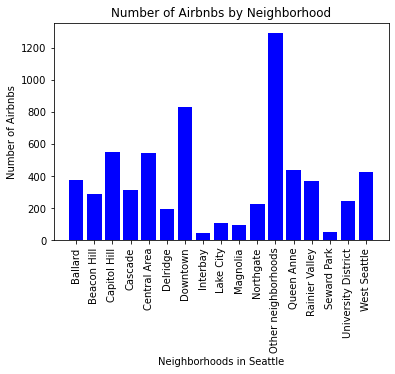

<Figure size 432x288 with 0 Axes>

In [15]:
data = abnb_data
fig, ax = plt.subplots()

x = list(data.keys())
y = list(data.values())

ax.bar(x, y, color="blue")

ax.set_ylabel('Number of Airbnbs')
ax.set_title('Number of Airbnbs by Neighborhood')
ax.set_xlabel('Neighborhoods in Seattle')

plt.xticks(rotation=90)
plt.show()
plt.savefig('airbnb_barchart.png')

Not counting the "Other neighborhoods" category, the area with the most Airbnbs is Downtown and the area with the least is Interbay. Remember that this is for all listings as of March 24, 2023. So, there can be listings from before 2022.

For finding the areas with the most and least crime reports, I will repeat the same steps as above, but with different dictionaries, keys, and values.

In [16]:
#Create empty dictionary to hold the counts
spd_data = {}
for area in mcpp:
    spd_data[area] = 0

#Fill in dictionary
for report in spd_raw_data:
    for neighborhood in spd_data:
        if report["mcpp"] == neighborhood:
            spd_data[neighborhood] += 1
pprint(spd_data)

{'<Null>': 1,
 'ALASKA JUNCTION': 1869,
 'ALKI': 556,
 'BALLARD NORTH': 1718,
 'BALLARD SOUTH': 3451,
 'BELLTOWN': 2318,
 'BITTERLAKE': 2166,
 'BRIGHTON/DUNLAP': 1220,
 'CAPITOL HILL': 6023,
 'CAPTIOL HILL': 1,
 'CENTRAL AREA/SQUIRE PARK': 2861,
 'CHINATOWN/INTERNATIONAL DISTRICT': 2670,
 'CLAREMONT/RAINIER VISTA': 747,
 'COLUMBIA CITY': 624,
 'COMMERCIAL DUWAMISH': 98,
 'COMMERCIAL HARBOR ISLAND': 57,
 'DOWNTOWN COMMERCIAL': 5976,
 'EASTLAKE - EAST': 178,
 'EASTLAKE - WEST': 779,
 'FAUNTLEROY SW': 324,
 'FIRST HILL': 3261,
 'FREMONT': 1827,
 'GENESEE': 367,
 'GEORGETOWN': 1604,
 'GREENWOOD': 1885,
 'HIGH POINT': 797,
 'HIGHLAND PARK': 1129,
 'HILLMAN CITY': 387,
 'JUDKINS PARK/NORTH BEACON HILL': 1253,
 'LAKECITY': 2602,
 'LAKEWOOD/SEWARD PARK': 381,
 'MADISON PARK': 356,
 'MADRONA/LESCHI': 1305,
 'MAGNOLIA': 1440,
 'MID BEACON HILL': 906,
 'MILLER PARK': 710,
 'MONTLAKE/PORTAGE BAY': 587,
 'MORGAN': 873,
 'MOUNT BAKER': 1719,
 'NEW HOLLY': 667,
 'NORTH ADMIRAL': 1031,
 'NORTH BEACON 

Now that we have the dictionary with the crime report counts by neighborhood, we can create bar charts to help answer which areas have the highest and lowest crime rates.

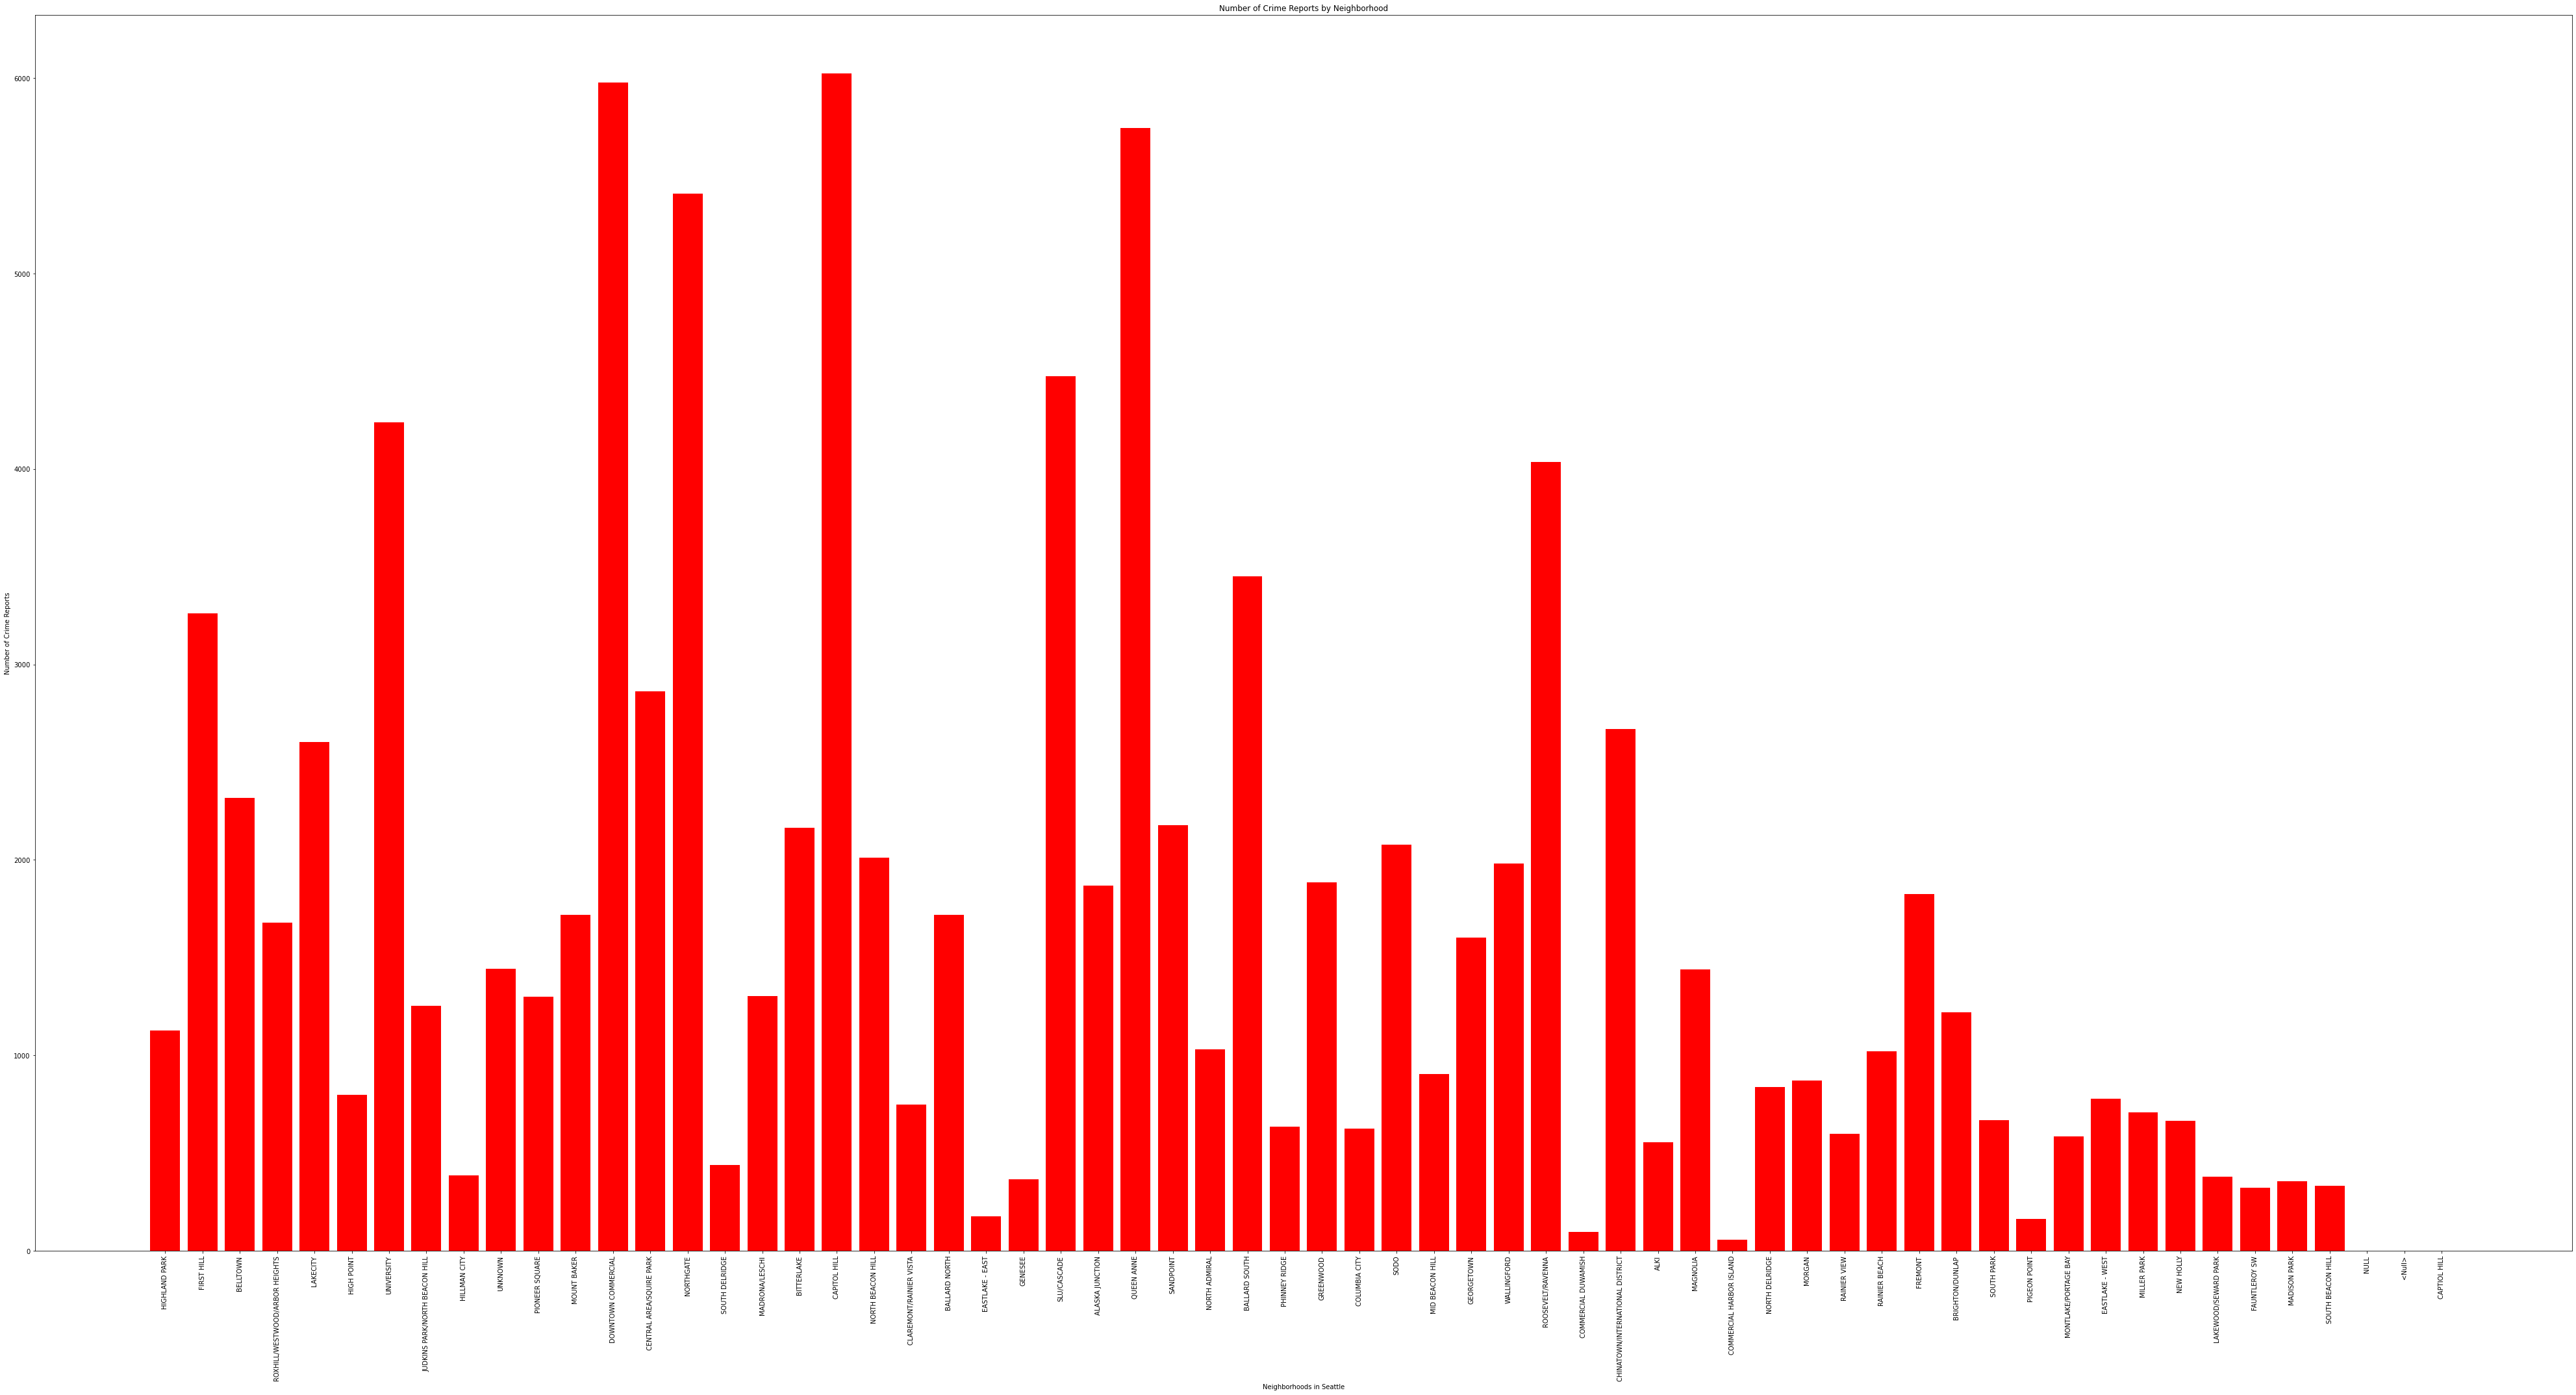

<Figure size 432x288 with 0 Axes>

In [17]:
data = spd_data
fig, ax = plt.subplots(figsize=(70, 35))

x = list(data.keys())
y = list(data.values())

ax.bar(x, y, color="red")

ax.set_ylabel('Number of Crime Reports')
ax.set_title('Number of Crime Reports by Neighborhood')
ax.set_xlabel('Neighborhoods in Seattle')

plt.xticks(rotation=90)
plt.show()
plt.savefig('spd_barchart.png')

Capitol Hill has the most crime reports while Commercial Harbor Island has the least.

* **Which offense types are the most and least frequent?**

To answer this, I plan to create a plot that contains the monthly count of each offense type in 2022 by neighborhood. The barchart will look similar to the one made above, however, it will include a legend for each crime-against category (person, society, property), and only include the crime reports made in 2022.

But first, I need to create dictionary with the proper counts by neighborhood and crimes against category.

In [18]:
#Create empty dictionary to hold the counts
spd_crime_22 = {"PROPERTY":{}, "PERSON":{}, "SOCIETY":{}, "NOT_A_CRIME":{}} # crime_against_category

for area in mcpp:
    spd_crime_22["PROPERTY"][area] = 0
    spd_crime_22["PERSON"][area] = 0
    spd_crime_22["SOCIETY"][area] = 0
    spd_crime_22["NOT_A_CRIME"][area] = 0

#Fill in dictionary
for report in spd_data_22:
    for neighborhood in mcpp:
        if report["mcpp"] == neighborhood and report["crime_against_category"] == "PROPERTY":
            spd_crime_22["PROPERTY"][neighborhood] += 1
        if report["mcpp"] == neighborhood and report["crime_against_category"] == "PERSON":
            spd_crime_22["PERSON"][neighborhood] += 1
        if report["mcpp"] == neighborhood and report["crime_against_category"] == "SOCIETY":
            spd_crime_22["SOCIETY"][neighborhood] += 1
        if report["mcpp"] == neighborhood and report["crime_against_category"] == "NOT_A_CRIME":
            spd_crime_22["NOT_A_CRIME"][neighborhood] += 1
#pprint(spd_crime_22)

Now that the dictionary is fully populated with the crime reports made in 2022, it is time to create visualixations.

                                PROPERTY  PERSON  SOCIETY  NOT_A_CRIME
HIGHLAND PARK                        630     123       47            0
FIRST HILL                          1500     528      232            0
BELLTOWN                            1159     343      126            0
ROXHILL/WESTWOOD/ARBOR HEIGHTS       912     154       54            0
LAKECITY                            1379     362      156            0
...                                  ...     ...      ...          ...
MADISON PARK                         189      14       17            0
SOUTH BEACON HILL                    190      45       15            0
NULL                                   0       0        0            0
<Null>                                 1       0        0            0
CAPTIOL HILL                           1       0        0            0

[62 rows x 4 columns]


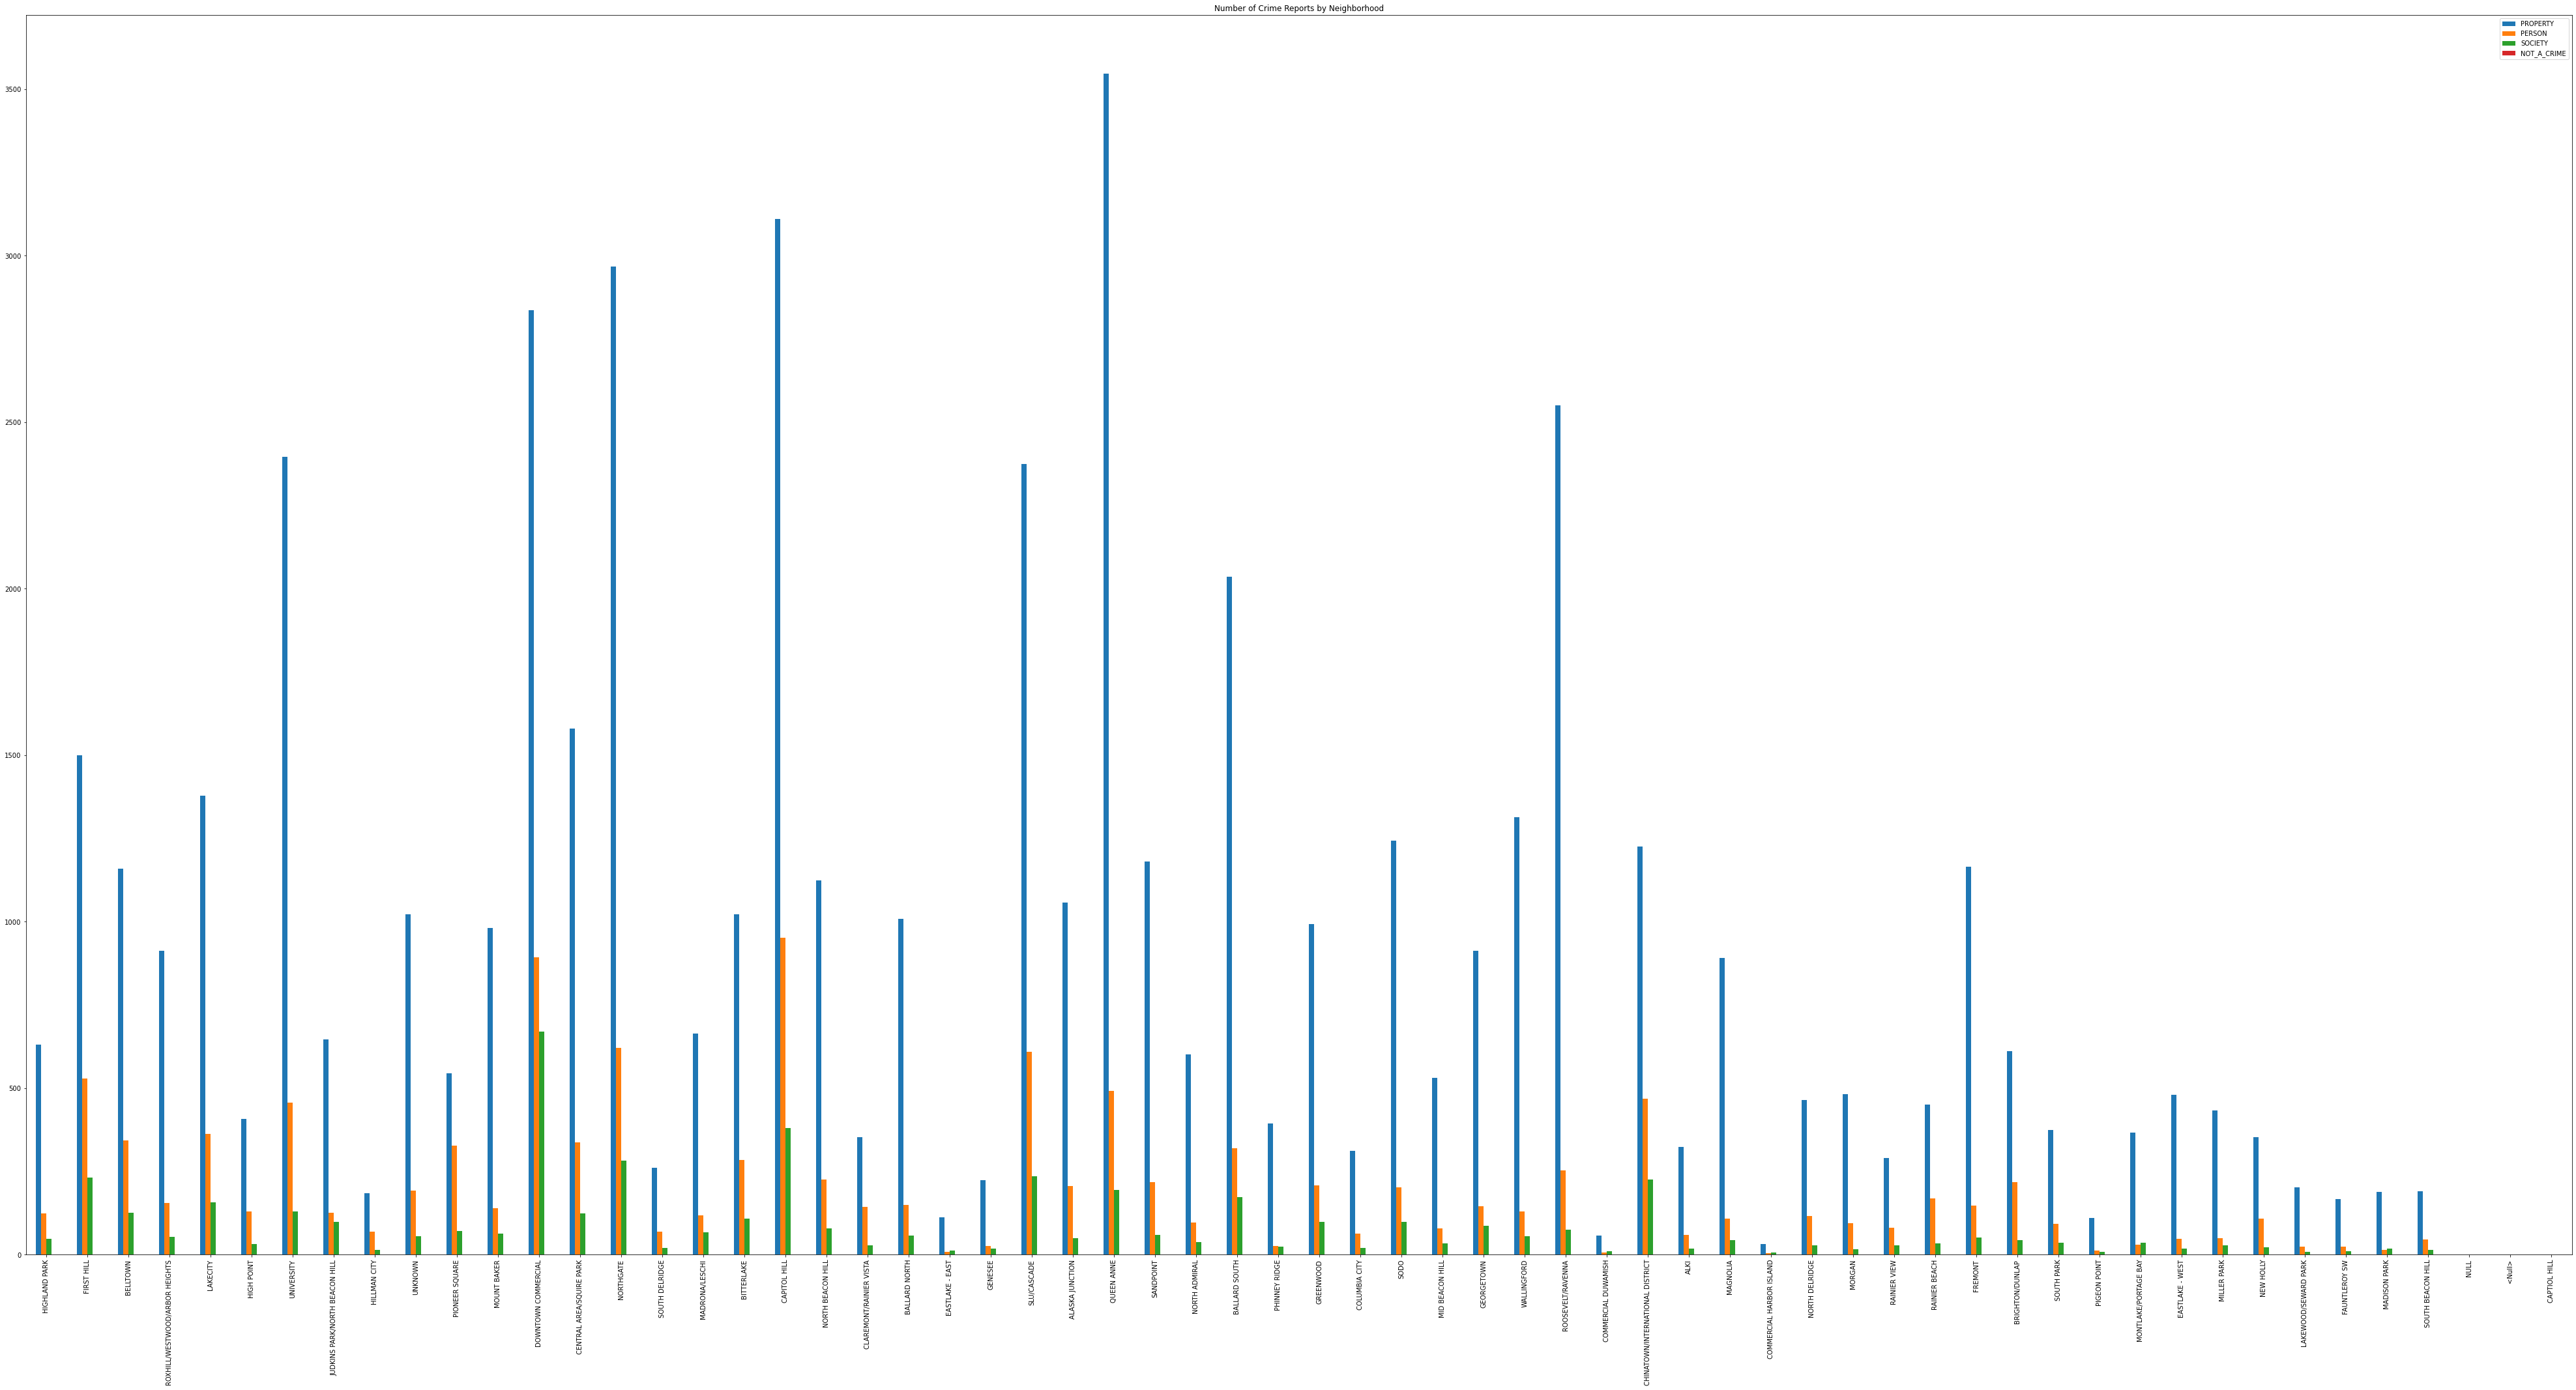

In [19]:
df = pd.DataFrame(spd_crime_22)
print(df)

df.plot.bar(title="Number of Crime Reports by Neighborhood", figsize=(70, 35))
plt.savefig('spd_22_barchart.png')

From this chart, we can see that there are significantly more crimes against property than people or society.

* **What is the relationship between Airbnbs and crime rates?**

Now that we have the visualizaiton of SPD Crime Data from 2022, we can compare it with the number of new Airbnbs listed in 2022. This will give greater insight on the relationship between the two, whereas the code for the first two research questions were more for understanding the individual datasets.

The following is a snipbit of the tabular representation of new Airbnbs that were listed in 2022. I created a new csv file that only contains the relevant parameters.

In [20]:
with open('airbnb_2022.csv', 'w', encoding='utf-8') as f:
    writer = csv.writer(f)
    #write a header row
    writer.writerow(('id',
                     'host_since',
                     'neighborhood', 
                     'latitude',
                     'longitude',
                     'first_review',
                     'last_review'
                    ))
    
    for listing in abnb_data_22:
        writer.writerow((listing['id'],
                         listing['host_since'],
                         listing['neighbourhood_group_cleansed'],
                         listing['latitude'],
                         listing['longitude'],
                         listing['first_review'],
                         listing['last_review']
                        ))
df = pd.read_csv("airbnb_2022.csv")
df.head()

,id,host_since,neighborhood,latitude,longitude,first_review,last_review
0,54121098.0,1/3/22,Capitol Hill,47.622173,-122.308182,5/4/22,3/20/23
1,54128002.0,1/3/22,Other neighborhoods,47.663372,-122.352074,4/20/22,3/18/23
2,54129542.0,1/3/22,West Seattle,47.546640,-122.377700,1/17/22,3/19/23
3,54151911.0,1/5/22,Ballard,47.677880,-122.389920,4/16/22,1/1/23
4,54167854.0,1/5/22,Northgate,47.715092,-122.333008,6/18/22,3/14/23


For this part, I tried to create a [scatter_mapbox using geopanda](https://plotly.com/python/scattermapbox/) but kept running into issues with invalid syntax.

In [21]:
import geopandas as gpd
geo_df = gpd.read_file(gpd.datasets.get_path("airbnb_2022.csv")

#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(geo_df,
                        lat=geo_df.geometry.y,
                        lon=geo_df.geometry.x,
                        hover_name="name",
                        zoom=1)
fig.show()

SyntaxError: invalid syntax (3836999333.py, line 5)

## Discussion
For future steps, I would want to continue using the cleaned data to create a timeline. This can help to visually see the relationship between Airbnbs being introduced to the area and crime rates. Although I couldn't fully answer the last research question, I understood more about the two datasets, especially the *SPD Crime Data*.

### Limitations and Implications
There were some limitations with this project due to my limited coding skills and time constraints. I spent a lot more time than expected cleaning the data and making sure I was aware of any missing values. I noticed that the *SPD Crime Data* in particular had some errors and missing data points like datetimes and neighborhoods. Additionally, the *Inside Airbnb* also had many limitations because it the nature of Airbnbs and homestays makes it difficult to understand its effects on neighborhoods since they are not permanent like other hospitality businesses. There is no indiciations of whether a host may stop and restart their listing.

## Conclusion
In conclusion, this project was a good start to tackling something bigger. I started this project with more commercial interests in mind, but now recognize the potential impact that homestay properties such as Airbnb have on neighborhood crime. Basic questions were answered like which areas had the higher rates of crime and Airbnb listings. It was found to be the Downtown area and Capitol Hill. Additionally, the area with the least amount of Airbnb listings and crime reports was Commercial Harbor Island and Interbay.

However, this research also led to more questions that highlight the importance of qualitative data in providing context to the datasets used. I hypothesized that areas with increased Airbnb listings will have higher rates of reported crime, which was somewhat true. Although the shared statistics may indicate some type of correlation, I need to consider other factors such as the population density when attempting to reach a more concrete conclusion.